---
# Examples of 2-D classifications using QDA and nearest-neighbor methods using Hart distillation and Wilson edition.
---

In this script, we show the differences in classification performances between the 
quadratic discriminant analysis (QDA) and several variants of the nearest-neighbor (NN) method. 

The methods are compared using series of 2-D datasets (observations), containing 2 classes, with an increasing level of spatial complexity. 

## The classification methods
The QDA method approximates the PDF of each class as a multi-normal gaussian distribution which parameters are 
adjusted to fit the observations. Hence, the parameters are estimated from the datasets and the 
QDA uses that information to model the boundary where the two class probabilities overlap. This 
defines the influence zone of each class.

The NN method is probably the most intuitive approach of all. Having a dataset made of observations X 
belonging to several classes, it assigns, to a location x, the class of the nearest observation X from that location.
       

## Classification speed <i>versus</i> performance
Parametric methods can be very powerful when they are applied to types of problems they 
were specifically designed to tackle. However, nonparametric methods, which are often intuitive 
and somewhat heuristic, are often used to handle more general situations.

Parametric methods require some time to train using a dataset but the classification time 
using new data is usually small. The opposite is observed with nonparametric methods. They have minimal 
training time but can take much longer time to classify new data. 

If we could reduce the size of a dataset without affecting the performances of nonparametric methods, 
we could increase their speed while still being able to handle more general situations. This is what 
we will show in this script 

## Methods for reducing the size of a dataset 
We use two heuristic methods that can be used independently but which are more powerful when combined:
<ol>
<li>Wilson edition </li>
<li>Hart condensation </li>
</ol>

Wilson edition removes problematic observations from a dataset (outliers, misclassified)

Hart condensation removes observations that do not contribute to classification. It has 
the largest impact of the two on the dataset reduction.


In [1]:
print(__doc__)

# Author: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: BSD

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
sns.set()

# Used for reproductibility of the results
np.random.seed(42)

Automatically created module for IPython interactive environment


# A few useful functions

Let us first define several functions that will be used to generate each classification example.

## Data normalization

In [2]:
def normalize_dataset(X, nbins):
    X = StandardScaler().fit_transform(X)
    x_min = 1.1 * X[:,0].min()
    x_max = 1.1 * X[:,0].max()
    y_min = 1.1 * X[:,1].min()
    y_max = 1.1 * X[:,1].max()

    # Generate a spatial grid where the PDF will be evaluated locally.
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nbins), np.linspace(y_min, y_max, nbins))
    Xgrid = np.c_[xx.ravel(), yy.ravel()]
    
    return (X, Xgrid, xx, yy, x_min, x_max, y_min, y_max)

## Classification results displaying function 

In [3]:
def display_classification_results(C_qda, C_NN, C_NNe, C_NNd, C_NNed, X, y, Xe, ye, Xd, yd, Xed, yed, 
                                   Xgrid, figName, drawQDAboundary=True):

    cm_dim = ListedColormap(['#00BB00', '#0000BB'])
    cm_bright = ListedColormap(['#00FF00', '#0000FF'])
    
    fig, axs = plt.subplots(2,3, figsize=(12,8), sharex=True, sharey=True) 
    for k in range(6):
        ax = axs.ravel()[k]

        if (k==0):
            # QDA classification results
            ax.pcolormesh(xx, yy, C_qda, cmap=cm_dim, norm=colors.Normalize(0., 1.), zorder=0) 
            ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='w', s=15, alpha = 0.6)
            if (drawQDAboundary==True):
                ax.contour(xx, yy, C_qda, [0.5], linewidths=2., colors='yellow') 
            ax.set_title('QDA', fontsize=16, color='k')
            
        elif (k==1):
            # Nearest-Neighbor classification results    
            ax.pcolormesh(xx, yy, C_NN, cmap=cm_dim, norm=colors.Normalize(0., 1.), zorder=0) 
            ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='w', s=15, alpha = 0.6)
            if (drawQDAboundary==True):
                ax.contour(xx, yy, C_qda, [0.5], linewidths=2., colors='yellow') 
            ax.set_title('Nearest-Neighbor', fontsize=16, color='k')
            
        elif (k==2):
            # Nearest-Neighbor classification results with Wilson Edition   
            ax.pcolormesh(xx, yy, C_NNe, cmap=cm_dim, norm=colors.Normalize(0., 1.), zorder=0) 
            ax.scatter(Xe[:, 0], Xe[:, 1], c=ye, cmap=cm_bright, edgecolors='w', s=15, alpha = 0.6)
            if (drawQDAboundary==True):
                ax.contour(xx, yy, C_qda, [0.5], linewidths=2., colors='yellow') 
            ax.set_title('NN + Wilson Edition', fontsize=16, color='k')

        elif (k==3):
            # Nearest-Neighbor classification results with Hart Distillation 
            ax.pcolormesh(xx, yy, C_NNd, cmap=cm_dim, norm=colors.Normalize(0., 1.), zorder=0) 
            ax.scatter(Xd[:, 0], Xd[:, 1], c=yd, cmap=cm_bright, edgecolors='w', s=15, alpha = 0.6)
            if (drawQDAboundary==True):
                ax.contour(xx, yy, C_qda, [0.5], linewidths=2., colors='yellow') 
            ax.set_title('NN + Hart Distillation', fontsize=16, color='k')

        elif (k==4):
            # Nearest-Neighbor classification results with Wilson Edition and Hart Distillation
            ax.pcolormesh(xx, yy, C_NNed, cmap=cm_dim, norm=colors.Normalize(0., 1.), zorder=0) 
            ax.scatter(Xed[:, 0], Xed[:, 1], c=yed, cmap=cm_bright, edgecolors='w', s=15, alpha = 0.6)
            if (drawQDAboundary==True):
                ax.contour(xx, yy, C_qda, [0.5], linewidths=2., colors='yellow') 
            ax.set_title('NN + Wilson Edition \n + Hart Distillation', fontsize=16, color='k')

        else:
            # Nearest-Neighbor classification results with Wilson Edition and Hart Distillation
            ax.pcolormesh(xx, yy, C_NNed, cmap=cm_dim, norm=colors.Normalize(0., 1.), zorder=0) 
            ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='w', s=15, alpha = 0.6)
            ax.set_title('NN + Wilson Edition \n + Hart Distillation + all data', fontsize=16, color='k')

        ax.set_xlim([x_min,x_max])
        ax.set_ylim([y_min,y_max])
        ax.set_xlabel('$x_{1}$', fontsize=14)
        ax.set_ylabel('$x_{2}$', fontsize=14, rotation=0) 
        ax.xaxis.set_label_coords(0.5, -0.05) 
        ax.yaxis.set_label_coords(-0.05, 0.5) 
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.grid(None)  
        ax.grid(None) 
    
    fig.tight_layout()
        
    plt.savefig(figName + '.png')
    plt.savefig(figName + '.pdf')

## Wilson Edition 
This heuristic method is used to remove misclassified or outlying data points. It has one parameter, the number of 
nearest neighbors used to test if a data point should be removed. 

For example, if n_Wilson=5 then for each data point, we find its class and the most frequent class among its five closest
neighbors. If both classes disaggree, the point is considered too different from its neighbors and we remove 
it from the dataset.
   

In [4]:
def wilson_edition(X, y, n_Wilson):
    clf = KNeighborsClassifier(n_neighbors=n_Wilson)

    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)

    X = X[idx,:]
    y = y[idx]

    pool_X = X
    pool_y = y
    npts =  pool_X.shape[0]

    i = 0
    while (i<npts):
        test_X = pool_X[i,:].reshape(1, -1)
        test_y = pool_y[i].reshape(-1)

        train_X = np.delete(pool_X,i,0)
        train_y = np.delete(pool_y,i,0)

        clf.fit(train_X, train_y.ravel())
        y_pred = clf.predict(test_X)
        if (test_y!=y_pred):
            pool_X = np.delete(pool_X,i,0)
            pool_y = np.delete(pool_y,i,0)
        else:
            i+=1
        
        npts = pool_X.shape[0]

    return (pool_X, pool_y.ravel())


## Hart Distillation
This heuristic method is used to remove data points that bring no useful information to the 
nearest-neighbor classification. 


In [5]:
def hart_distillation(X,y):
    clf = KNeighborsClassifier(n_neighbors=1)

    # Shuffle the dataset
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    X = X[idx,:]
    y = y[idx]

    # Initialise the prototype with a single data point
    prototype_X = X[0,:].reshape(1, -1)
    prototype_y = y[0].reshape(-1)

    # The remaining data points are excluded from the prototype
    remain_X = np.delete(X,0,0)
    remain_y = np.delete(y,0,0)

    new_size =  prototype_X.shape[0]
    old_size = -1
    
    # Iterate until no more remaining data point can be inserted into the prototype
    while (new_size != old_size):
        # Pass a few times over the set of remaining data points
        pool_X = remain_X
        pool_y = remain_y

        while (pool_y.shape[0] != 0):
            clf.fit(prototype_X, prototype_y.ravel())
            y_pred = clf.predict(pool_X[0,:].reshape(1, -1))
            if (pool_y[0]!=y_pred):
                # Useful data point. Insert it into the prototype
                prototype_X = np.vstack((prototype_X,pool_X[0,:]))
                prototype_y = np.vstack((prototype_y,pool_y[0].ravel()))
                # Remove it from the list of remaining data points to test
                remain_X = np.delete(remain_X,0,0)
                remain_y = np.delete(remain_y,0,0)

            # Remove the data point from the pool 
            pool_X = np.delete(pool_X,0,0)
            pool_y = np.delete(pool_y,0,0)
            
        old_size = new_size
        new_size = prototype_X.shape[0]

    return (prototype_X, prototype_y.ravel())


## Multi-classification function

In [6]:
def classify(X, y, Xgrid, xx, nWilson=3):
    # QDA classification results used as reference
    C_qda = qda.fit(X, y).predict(Xgrid) 
    C_qda = C_qda.reshape(xx.shape)

    # Nearest-Neighbor classification results (vanilla version)  
    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(X, y)
    c = clf.predict(Xgrid)
    C_NN = c.reshape(xx.shape)

    # Nearest-Neighbor classification results with Wilson Edition (add some toppings)
    (Xe, ye) = wilson_edition(X,y, nWilson)
    clf.fit(Xe, ye)
    c = clf.predict(Xgrid)
    C_NNe = c.reshape(xx.shape)

    # Nearest-Neighbor classification results with Hart Distillation (add some more toppings)
    (Xd, yd) = hart_distillation(X,y)
    clf.fit(Xd, yd)
    c = clf.predict(Xgrid)
    C_NNd = c.reshape(xx.shape)

    # Nearest-Neighbor classification results with Wilson Edition and Hart Distillation (add lots of toppings)
    (Xed, yed) = hart_distillation(Xe,ye)
    clf.fit(Xed, yed)
    c = clf.predict(Xgrid)
    C_NNed = c.reshape(xx.shape)
    
    # Display statistics showing the number of data points used in each step
    d = np.array([X.shape[0], Xe.shape[0], Xd.shape[0], Xed.shape[0]])
    p = (100*d/d[0]).astype(int)
    print('\n\nN_{total} = %d  (%d %%) \n' % (d[0], p[0]) )
    print('N_{nearest neighbor + Wilson edition} = %d  (%d %%) \n' % (d[1], p[1]))
    print('N_{nearest neighbor + Hart condensation} = %d  (%d %%) \n' % (d[2], p[2]))
    print('N_{nearest neighbor + edition + condensation} = %d  (%d %%)  \n\n' % (d[3], p[3]))    
    
    
    return (C_qda, C_NN, C_NNe, C_NNd, C_NNed, Xe, ye, Xd, yd, Xed, yed)

# Examples of classifications using the QDA and several versions of the Nearest-Neighbor method 
### Initialisations

In [7]:
# Number of spatial bins used in each spatial direction 
nbins = 500

# Quadratic discriminant analysis classifier
qda = QuadraticDiscriminantAnalysis(store_covariance=True)

## 1) Small dataset made of two concentric noisy circles without overlap (easy case)  

In this example, the QDA method should produce excellent results; it is used as a refererence for the other methods.

Since the data points for each class are well separated, there are no outliers or misclassified point. The Wilson edition 
should have no effect on the dataset. 

The Hart condensation however will reduce its size. 


In [8]:
# Generate dataset
npts = 200
X,y = datasets.make_circles(n_samples=npts, factor=.5, noise=.05)

# Normalize dataset
(X, Xgrid, xx, yy, x_min, x_max, y_min, y_max) = normalize_dataset(X, nbins)

# Classify dataset and print the number of remaining datapoints at each step
(C_qda, C_NN, C_NNe, C_NNd, C_NNed, Xe, ye, Xd, yd, Xed, yed) = classify(X, y, Xgrid, xx, nWilson=3)



N_{total} = 200  (100 %) 

N_{nearest neighbor + Wilson edition} = 200  (100 %) 

N_{nearest neighbor + Hart condensation} = 13  (6 %) 

N_{nearest neighbor + edition + condensation} = 12  (6 %)  




### Display the results  

In all panels, except for the last one, the QDA boundary is overlaid on the NN results as a reference.

This example shows two concentric and well separated data distributions. The second and third panels in the first 
row show identical results as expected. In principle, the first two panels in the second row should be the same 
as the Wilson edition has no effect of the dataset. However, the method is heuristic and may produce different 
results everytime.

The last panel shows the new classification results. The boundary is not smooth but all data points are correctly classified.


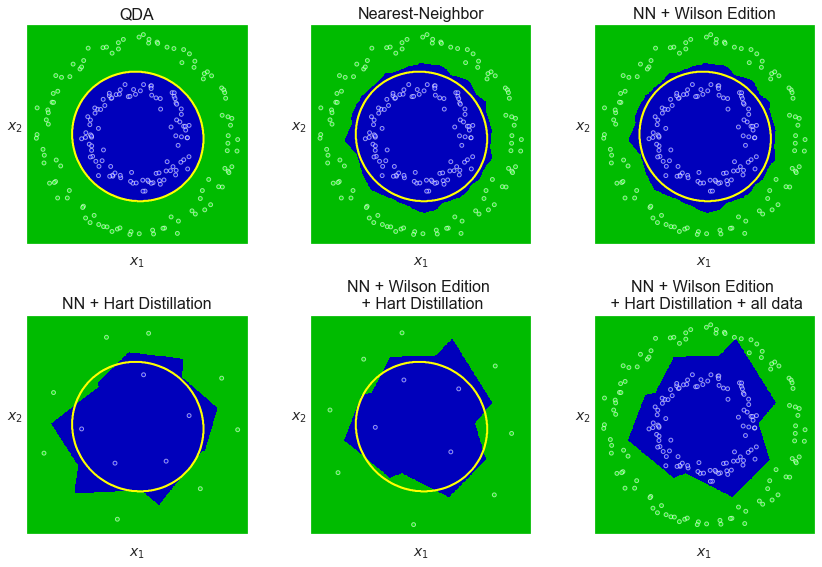

In [9]:
# Compare classification results
figName = '2D_NN_with Hart_Wilson_classif_circles_1'
display_classification_results(C_qda, C_NN, C_NNe, C_NNd, C_NNed, X, y, Xe, ye, Xd, yd, Xed, yed, Xgrid, figName)


## 2) Noisy, concentric and overlapping circles with lots of data points (hard case)

In this example, the QDA method should produce again excellent results.

Because we are looking for a boundary between noisy data distributions that overlap, some points will be considered as 
misclassified because they are on the wrong side of the boundary. The Wilson edition will identify and remove them. 
As a result, the Hart condensation will be less affected by problematic data points and will produce better 
classifications with fewer data points.

You can play with the number of nearest neighbors in the Wilson edition (parameter nWilson) to see the effect 
on the final results.

In [10]:
# Generate dataset
npts = 500
X,y = datasets.make_circles(n_samples=npts, factor=.75, noise=.1)

# Normalize dataset
(X, Xgrid, xx, yy, x_min, x_max, y_min, y_max) = normalize_dataset(X, nbins)

# Classify dataset and print the number of remaining datapoints at each step
(C_qda, C_NN, C_NNe, C_NNd, C_NNed, Xe, ye, Xd, yd, Xed, yed) = classify(X, y, Xgrid, xx, nWilson=15)




N_{total} = 500  (100 %) 

N_{nearest neighbor + Wilson edition} = 449  (89 %) 

N_{nearest neighbor + Hart condensation} = 137  (27 %) 

N_{nearest neighbor + edition + condensation} = 62  (12 %)  




### Display the results  

Notice how the Wilson edition improves the results from the NN method alone. 
By itself, the Hart condensation greatly reduces the dataset used for the classification but it is 
not robust to misclassified points (on the wrong side of the boundary). Those problematic data points are discarded
by the Wilson edition and the combinaton of both methods now produces excellent results. The new edgy boundary 
is close to the smooth QDA boundary and uses about 8 times less data points.    

The last panel shows the new classification results. The boundary is not smooth but most data points are correctly classified.


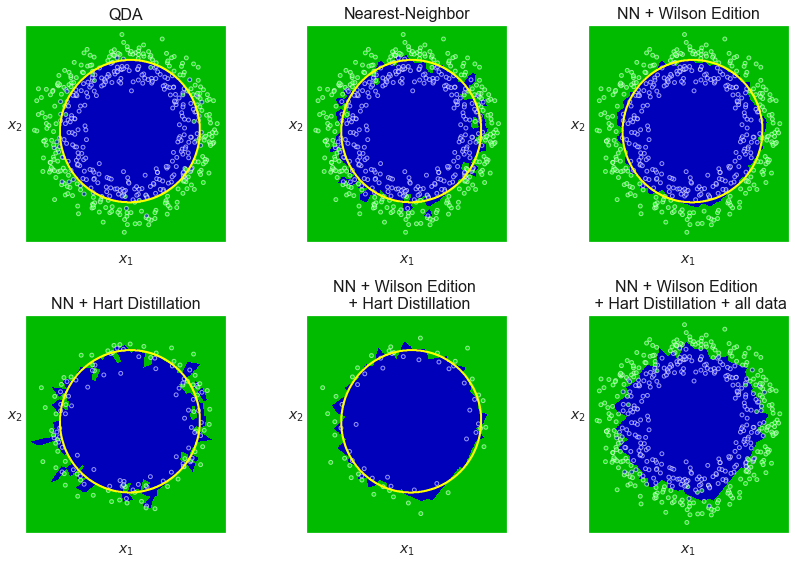

In [11]:
# Compare classification results
figName = '2D_NN_with Hart_Wilson_classif_circles_2'
display_classification_results(C_qda, C_NN, C_NNe, C_NNd, C_NNed, X, y, Xe, ye, Xd, yd, Xed, yed, Xgrid, figName)

# 3) Noisy crescents (a much harder case)

This example shows a more complex boundary. In this situation, the QDA method cannot well delineate the influence zones since 
the boundary can be neither linear nor quadratic. The various NN methods should fare better here.

You can play with the number of nearest neighbors in the Wilson edition (parameter nWilson) to see the effect 
on the final results.

In [12]:
# Generate dataset
npts = 500
X,y = datasets.make_moons(n_samples=npts, noise=.15)

# Normalize dataset
(X, Xgrid, xx, yy, x_min, x_max, y_min, y_max) = normalize_dataset(X, nbins)

# Classify dataset and print the number of remaining datapoints at each step
(C_qda, C_NN, C_NNe, C_NNd, C_NNed, Xe, ye, Xd, yd, Xed, yed) = classify(X, y, Xgrid, xx, nWilson=15)



N_{total} = 500  (100 %) 

N_{nearest neighbor + Wilson edition} = 493  (98 %) 

N_{nearest neighbor + Hart condensation} = 36  (7 %) 

N_{nearest neighbor + edition + condensation} = 13  (2 %)  




### Display the results  

The standard NN method is better than the QDA but is also sensitive to a few misclassified points. 
The Wilson edition does a good job at removing those problematic points; the boundary outline is already more continuous. 

The first panel on the second row shows how the Hart distillation alone can drastically reduce the number of data points 
required for realistic classification. However, it is also very chaotic and should change considerably with another
random dataset. 

The next panel shows the regularization effect of the Wilson edition on the Hart distillation. 
There are still very few data points left but the boundary now looks more realistic. This can be seen in the last panel were 
the previous boundary is superposed on the initial data distribution. Isn't that amazing to see that so few remaining 
points after distillation are enough to generate almost perfectly the influence zone of each class!


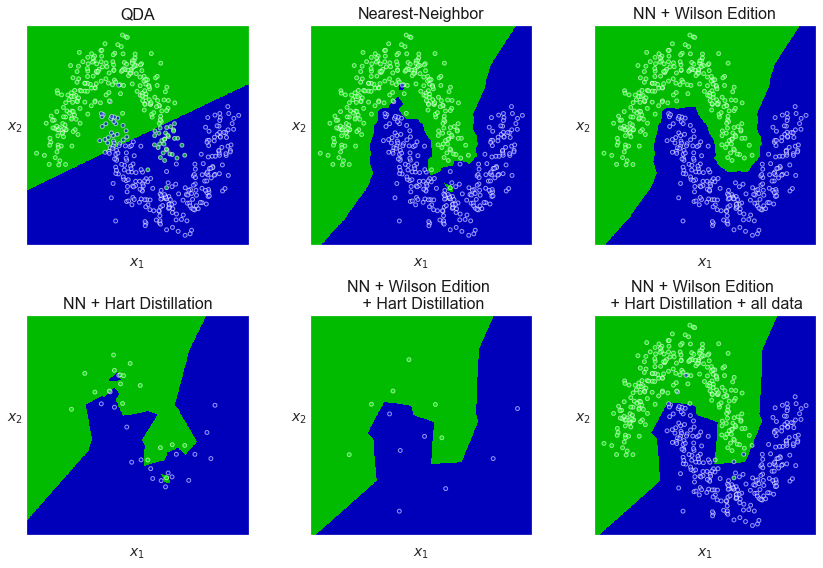

In [13]:
# Compare classification results
figName = '2D_NN_with Hart_Wilson_classif_crescents'
display_classification_results(C_qda, C_NN, C_NNe, C_NNd, C_NNed, X, y, Xe, ye, Xd, yd, Xed, yed, Xgrid, figName, drawQDAboundary=False)